# ISS AI Docking Locator and Distance Regressor Project

Neil Ghugare, Nishanth Kunchala, Pranav Moola, and Jacob Balek

### Imports and Data Fetching

In [1]:
import os
import random
import json
import pickle

import tensorflow as tf
import kagglehub as kh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

c:\Users\Nishanth Kunchala\.conda\envs\wildfire\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Nishanth Kunchala\.conda\envs\wildfire\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Nishanth Kunchala\.conda\envs\wildfire\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Nishanth Kunchala\.conda\envs\wildfire\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Nishanth Kunchala\.conda\envs\wildfire\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebo

### Set up GPU acceleration

In [2]:

os.environ["CUDA_VISIBLE_DEVICES"] = "0"    # -1 --> CPU and 0 --> GPU 

gpus = tf.config.list_physical_devices('GPU')

if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=14000)] # Memory limit is in MB here --> 14 GB of ram | CHANGE BASED ON SYSTEM SPECS
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")


1 Physical GPU, 1 Logical GPUs


We set a random seed to ensure reproducible results with Tensorflow randomization.

In [3]:
tf.random.set_seed(42)

We fetch the data using KaggleAPI and then read it into a Pandas DataFrame.

In [4]:
path = kh.dataset_download("msafi04/iss-docking-dataset")
# path = "/Users/rajkunchala/Documents/GitHub/HackAI2025/Rotated_Data/"
print(path)

C:\Users\Nishanth Kunchala\.cache\kagglehub\datasets\msafi04\iss-docking-dataset\versions\1


In [5]:
df = pd.read_csv(os.path.join(path, 'train.csv'))

In [6]:
df.head()

,ImageID,distance,location
0,0,351,"[215, 158]"
1,1,372,"[228, 269]"
2,2,488,"[255, 386]"
3,3,308,"[306, 426]"
4,4,67,"[248, 338]"


In [7]:
n_imgs = len(df)
n_imgs

10000

Below is a histogram of the distance values from the data. It is roughly uniform, but there are less data points for smaller distances.

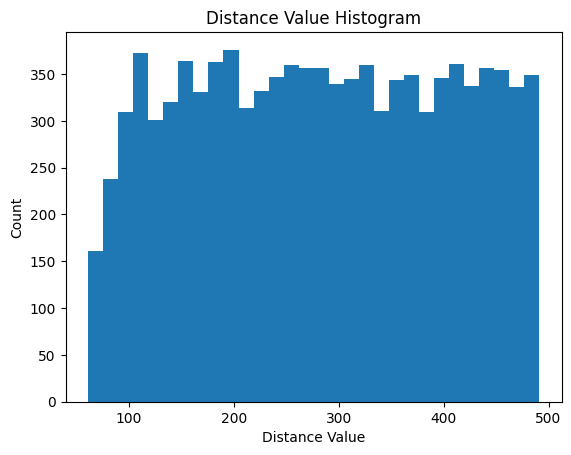

In [8]:
plt.hist(df['distance'], bins=30)
plt.xlabel('Distance Value')
plt.ylabel('Count')
plt.title('Distance Value Histogram')
plt.show()

To visualize the location data, we make a 2D heat map. 

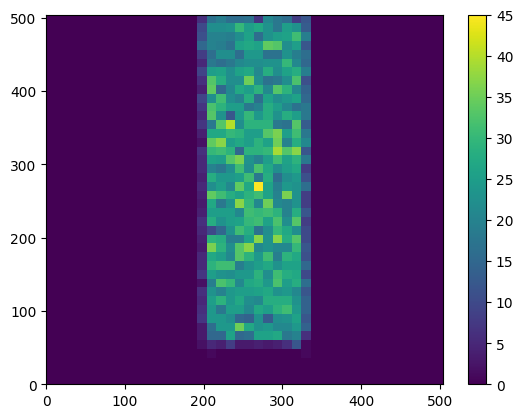

In [9]:
locations = tuple(map(lambda x: tuple(json.loads(x)), df['location']))
locations = np.array(locations)
x, y = locations[:,0], locations[:, 1]

plt.hist2d(x,y, bins=[np.arange(0, 512, 12),np.arange(0, 512, 12)])
plt.colorbar()
plt.show()

We repeat the same thing in three dimensions to see the data a bit better.

In [10]:
img_width = img_height = 512
batch_size = 16

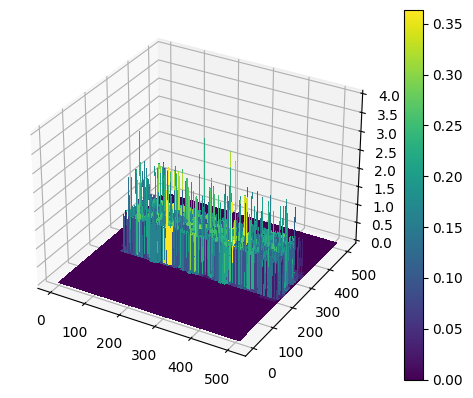

In [11]:
x = np.arange(0, img_width, 1)
y = np.arange(0, img_height, 1)

x, y = np.meshgrid(x, y)
z = np.zeros(x.shape)

for _ in df['location']:
    coord = tuple(json.loads(_))
    z[coord[0]][coord[1]] += 1

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, z, cmap='viridis',
                       linewidth=0, antialiased=False)
fig.colorbar(surf)
plt.show()


In [12]:
del x, y, z, locations

### Data Preparation

We get the image paths in the local directory and ensure that the length of this list equals the total sample size of the dataset (10,000). We then isolate the distance and location columns in the DataFrame.

In [13]:
image_paths = []
for f in os.listdir(os.path.join(path, 'train')):
    if f.startswith('.') or '.jpg' not in f:
        continue
    image_paths.append(os.path.join(path, 'train', f))
len(image_paths)

10000

In [14]:
distances = df.get('distance').tolist()
locations = df.get('location').tolist()

distances[:5]

[351, 372, 488, 308, 67]

Then we sort the image paths so that way all the images are in order from 0-9999.

In [15]:
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

We zip the paths and distances and the paths with locations. We then shuffle both of the zips with the same random seed, so that way each image still matches with its distance and location value. This also allows for reproducable results in the model later. After shuffling, we unzip to retrieve the lists once again.

In [16]:
combined_distances = list(zip(image_paths, distances))
combined_locations = list(zip(image_paths, locations))
random.Random(42).shuffle(combined_distances)
random.Random(42).shuffle(combined_locations)

In [17]:
image_paths_distances, distances = zip(*combined_distances)
image_paths_locations, locations = zip(*combined_locations)

We choose a 70-10-20 training, validation, and test split for the data.

In [18]:
train_split = int(0.7*n_imgs)
val_split = train_split + int(0.1*n_imgs)
test_split = val_split + int(0.2*n_imgs)
print(train_split, val_split, test_split)

7000 8000 10000


We then get the train image paths for the distances and locations and then get the train distances and locations. We repeat this for test and validation sets. The image paths for distances and locations will actually be exactly the same due to the prior random seeding, so we only need one for future use.

In [19]:

train_image_paths_distances = np.array(image_paths_distances[:train_split]).flatten()
train_distances = np.array(distances[:train_split]).flatten()
train_image_paths_locations = np.array(image_paths_locations[:train_split]).flatten()
train_locations = locations[:train_split]

val_image_paths_distances = np.array(image_paths_distances[train_split:val_split]).flatten()
val_distances = np.array(distances[train_split:val_split]).flatten()
val_image_paths_locations = np.array(image_paths_locations[train_split:val_split]).flatten()
val_locations = locations[train_split:val_split]

test_image_paths_distances = np.array(image_paths_distances[val_split:test_split]).flatten()
test_distances = np.array(distances[val_split:test_split]).flatten()
test_image_paths_locations = np.array(image_paths_locations[val_split:test_split]).flatten()
test_locations = locations[val_split:test_split]

We normalize the location values from [0, 512] to [0, 1] by simply dividing by 512. We can do it this simply since the image is square of size 512x512.

In [20]:
train_locations = tuple(map(lambda x: tuple(json.loads(x)), train_locations))
train_locations = np.array(train_locations)/512

val_locations = tuple(map(lambda x: tuple(json.loads(x)), val_locations))
val_locations = np.array(val_locations)/512

test_locations = tuple(map(lambda x: tuple(json.loads(x)), test_locations))
test_locations = np.array(test_locations)/512

We do the same for the distances, reshaping the data to [0, 1].

In [21]:
max_distance = np.max(distances)
min_distance = np.min(distances)
print(min_distance, max_distance)

train_distances = (train_distances-min_distance)/(max_distance-min_distance)
val_distances = (val_distances-min_distance)/(max_distance-min_distance)
test_distances = (test_distances-min_distance)/(max_distance-min_distance)

61 491


In [22]:
print(np.max(train_locations))
print(np.min(train_locations))

0.99609375
0.09375


In [23]:
print(np.max(train_distances))
print(np.min(train_distances))

1.0
0.0


We define a function `as_image` that reads the image path as an array, and reads in the RGB values. Then the RGB values are normalized to [0, 1] by dividing by 255. The processed image is returned. We apply this to the image paths lists.

In [24]:
def as_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_height, img_width))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image

In [25]:
def gaussian_label_smoothing(x, num_bins=512, sigma=3):
    # Create a soft probability distribution centered at x using a Gaussian.
    bins = np.arange(num_bins)
    soft_label = scipy.stats.norm.pdf(bins, loc=x, scale=sigma)  # Gaussian centered at x
    soft_label /= soft_label.sum()  # Normalize to sum to 1 (valid probability distribution)
    
    return soft_label

In [26]:
# Function to convert (x, y) coordinate labels into one-hot probability maps
def convert_labels_to_heatmaps(x_coords, y_coords, img_size=512, sigma = 3):
    x_labels = np.array([gaussian_label_smoothing(x, img_size, sigma) for x in x_coords])
    y_labels = np.array([gaussian_label_smoothing(y, img_size, sigma) for y in y_coords])
    return x_labels, y_labels

In [27]:
def create_dataset(paths, dists, locs):
    dataset = tf.data.Dataset.from_tensor_slices((paths, dists, locs))
    dataset = dataset.map(lambda i, d, xy: (as_image(i), {'distance': d, 'x': xy[0], 'y': xy[1]}), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Convert (x, y) labels into one-hot encoded heatmaps
train_x_heatmaps, train_y_heatmaps = convert_labels_to_heatmaps(train_locations[:, 0] * 512, train_locations[:, 1] * 512)
val_x_heatmaps, val_y_heatmaps = convert_labels_to_heatmaps(val_locations[:, 0] * 512, val_locations[:, 1] * 512)
test_x_heatmaps, test_y_heatmaps = convert_labels_to_heatmaps(test_locations[:, 0] * 512, test_locations[:, 1] * 512)

train_dataset = create_dataset(train_image_paths_distances, train_distances, (train_x_heatmaps, train_y_heatmaps))
val_dataset = create_dataset(val_image_paths_distances, val_distances, (val_x_heatmaps, val_y_heatmaps))
test_dataset = create_dataset(test_image_paths_distances, test_distances, (test_x_heatmaps, test_y_heatmaps))

### Model

We choose `MobileNetV3Small` for fine-tuning of our multi-headed network (MHN). We chose this model in order to use its strong convolutional power while saving computational time and resources (as models like `VGG16` or `ResNet` architecture are bigger). We freeze this model, making it not trainable. We use the default `imagenet` weights and we choose not to include the top layer so we can build our MHN on it.

In [28]:
net = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
net.trainable = False

InvalidArgumentError: Multiple OpKernel registrations match NodeDef at the same priority '{{node RandomUniform}}': 'op: "RandomUniform" device_type: "GPU" constraint { name: "T" allowed_values { list { type: DT_INT32 } } } constraint { name: "dtype" allowed_values { list { type: DT_FLOAT } } } host_memory_arg: "shape"' and 'op: "RandomUniform" device_type: "GPU" constraint { name: "T" allowed_values { list { type: DT_INT32 } } } constraint { name: "dtype" allowed_values { list { type: DT_FLOAT } } } host_memory_arg: "shape"' [Op:RandomUniform]

In [ ]:
# If this is commented out, it is to reduce file length as this output is long
# net.summary()

In [ ]:
'''
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # Reduce when val_loss stops improving
    factor=0.5,          # Halve learning rate
    patience=2,          # Wait 2 epochs before reducing
    min_lr=1e-7,         # Minimum learning rate
    min_delta=1e-5,      # Minimum delta needed to trigger ReduceLROnPlateau()
    verbose=1
)
'''
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=25000,
    decay_rate=0.95,
    staircase=True
)

We create our MHN using Tensorflow's functional API. We set a learning rate and epochs and flatten the output of the net. We then define the three regression heads and create the model using those outputs. We use MAE for the error and loss for all heads, and weight the losses based on experimental trials. We use the `Adam` optimizer.

In [ ]:
lr = 1e-4
epochs = 100

conv = net.output
conv = tf.keras.layers.Conv2D(64, (5, 5), activation='swish', padding='same')(conv)
conv = tf.keras.layers.Conv2D(64, (3, 3), activation='swish', padding='same')(conv)
conv = tf.keras.layers.Conv2D(32, (3, 3), activation='swish', padding='same')(conv)
spp1 = tf.keras.layers.GlobalAveragePooling2D()(conv)
spp2 = tf.keras.layers.GlobalMaxPooling2D()(conv)
spp = tf.keras.layers.Concatenate()([spp1, spp2])  # Combine both features
flatten = tf.keras.layers.Flatten()(spp)

# DISTANCE REGRESSION
regression = tf.keras.layers.Dense(16, activation='relu')(flatten)
dropout = tf.keras.layers.Dropout(0.05)(regression)
left_head = tf.keras.layers.Dense(8, activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.025)(left_head)
left_head = tf.keras.layers.Dense(4, activation='relu')(dropout)
left_head = tf.keras.layers.Dense(1, activation='linear', name='distance')(left_head)

# LOCATION X HEATMAP HEAD
regression = tf.keras.layers.Dense(16, activation='swish')(flatten)
middle_head = tf.keras.layers.Dense(8, activation='swish')(regression)
middle_head = tf.keras.layers.Dense(512, activation='swish')(middle_head)  # Output heatmap size (512 bins)
middle_head = tf.keras.layers.Dense(512, activation='linear')(middle_head)  # Pre-softmax logits
middle_head = tf.keras.layers.Softmax(name='x')(middle_head)  # Probability distribution

# LOCATION Y HEATMAP HEAD
regression = tf.keras.layers.Dense(8, activation='swish')(flatten)
dropout = tf.keras.layers.Dropout(0.25)(regression)
right_head = tf.keras.layers.Dense(4, activation='swish')(dropout)
right_head = tf.keras.layers.Dense(512, activation='swish')(regression)  # Output heatmap size (512 bins)
right_head = tf.keras.layers.Dense(512, activation='linear')(right_head)  # Pre-softmax logits
right_head = tf.keras.layers.Softmax(name='y')(right_head)  # Probability distribution

# Define the model
model = tf.keras.Model(inputs=net.input, outputs=(left_head, middle_head, right_head))

# Define losses (using categorical crossentropy for heatmaps)
losses = { 
    'distance': 'mean_absolute_error', 
    'x': 'kl_divergence', 
    'y': 'kl_divergence' 
}
loss_weights = { 'distance': 0.4, 'x': 0.25, 'y': 0.35 }

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss=losses, optimizer=opt, loss_weights=loss_weights)

# If this is commented out, it is to reduce file length as this output is long
# print(model.summary())

We define the train, test, and validation targets. We use `EarlyStopping` monitoring validation loss and `ModelCheckpoint` saving the best model also based on validation loss as callbacks. We then fit the model.

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='heatmap_model.keras', monitor='val_loss', save_best_only=True)
             ]
print(train_dataset)
history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), {'distance': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'x': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None), 'y': TensorSpec(shape=(None, 512), dtype=tf.float64, name=None)})>
Epoch 1/100
194/438 ━━━━━━━━━━━━━━━━━━━━ 1:15 309ms/step - distance_loss: 0.2097 - loss: 2.3025 - x_loss: 0.7999 - y_loss: 1.2930

KeyboardInterrupt: 

### Best Model Loss Table

| Dataset | Total Loss | Distance Loss | X Loss | Y Loss |
|---------|------------|---------------|--------|--------|
| Test    | 0.3410     | 0.0229        | 0.1022 | 0.2159 |

### Analysis

We plot the model loss per epoch, the distance loss per epoch, the x-coordinate loss per epoch, and the y-coordinate loss per epoch.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
# plt.ylim(0,0.1)
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss5.png')
plt.show()

In [ ]:
plt.plot(history.history['distance_loss'])
plt.plot(history.history['val_distance_loss'])
# plt.ylim(0,0.05)
plt.title('Model Distance MAE')
plt.ylabel('Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('distancemae5.png')
plt.show()

In [ ]:
plt.plot(history.history['x_loss'])
plt.plot(history.history['val_x_loss'])
# plt.ylim(0,0.01)
plt.title('Model X MAE')
plt.ylabel('X Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('xmae5.png')
plt.show()

In [ ]:
plt.plot(history.history['y_loss'])
plt.plot(history.history['val_y_loss'])
# plt.ylim(0,0.03)
plt.title('Model Y MAE')
plt.ylabel('Y Mean Squared Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('ymae5.png')
plt.show()

We evaluate the *latest* model on the test set, just to get a preliminary feel. We also make predictions on the test set.

In [ ]:
model.evaluate(test_dataset)

  7/125 ━━━━━━━━━━━━━━━━━━━━ 1:04 545ms/step - distance_loss: 0.1866 - loss: 2.0438 - x_loss: 0.6027 - y_loss: 1.2545

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model("best_xy_heatmap_model.keras")

In [ ]:
def heatmap_to_weighted_coords(heatmap_x, heatmap_y, top_k=10):
    """Extracts (x, y) coordinates by computing a weighted average of the top-k probabilities."""
    
    # Get the top-k indices based on probability values
    top_x_indices = np.argsort(heatmap_x)[-top_k:]  # Indices of top 10 probabilities for x
    top_y_indices = np.argsort(heatmap_y)[-top_k:]  # Indices of top 10 probabilities for y
    
    # Get corresponding probabilities
    top_x_probs = heatmap_x[top_x_indices]
    top_y_probs = heatmap_y[top_y_indices]
    
    # Normalize probabilities so they sum to 1 (convert them into weights)
    top_x_probs /= np.sum(top_x_probs)
    top_y_probs /= np.sum(top_y_probs)
    
    # Compute the weighted average of the top-k indices
    pred_x = np.sum(top_x_indices * top_x_probs)  # Weighted sum for x
    pred_y = np.sum(top_y_indices * top_y_probs)  # Weighted sum for y
    
    return pred_x, pred_y  # More stable keypoint prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


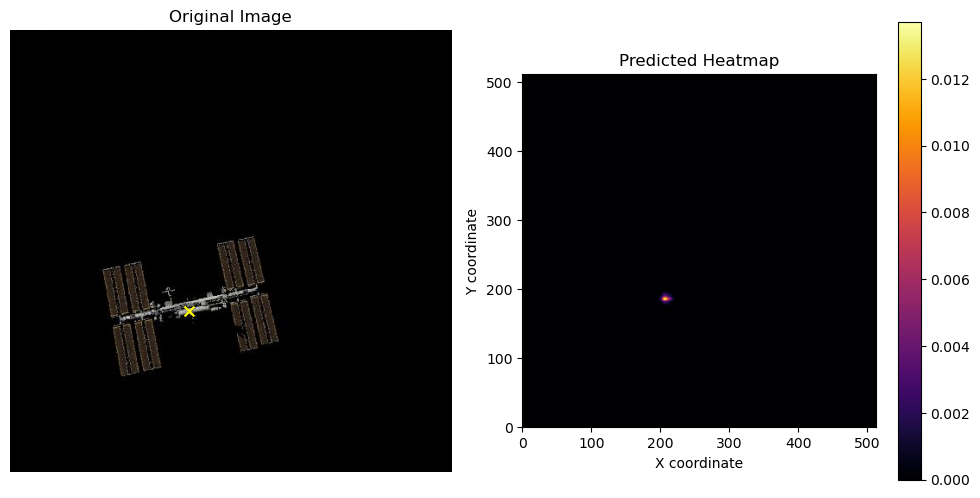

Predicted Keypoint: (207.25, 325.68) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/9306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


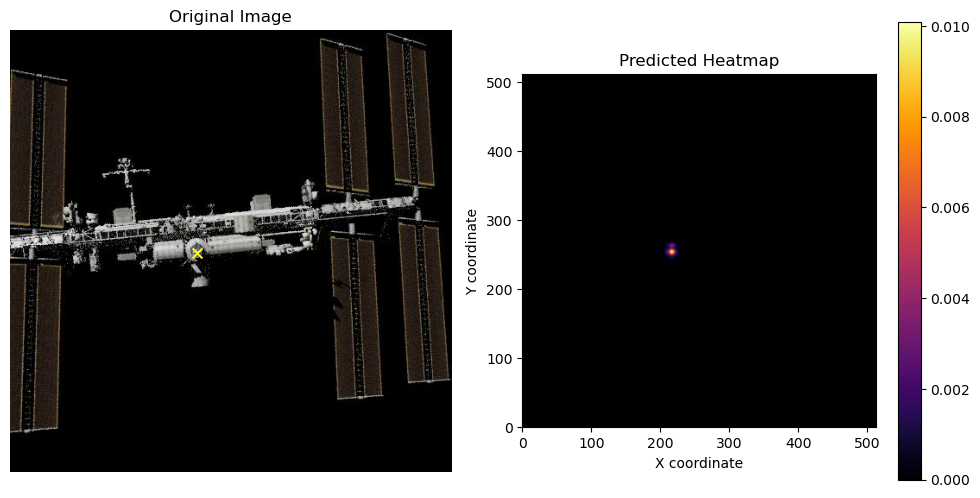

Predicted Keypoint: (216.38, 257.57) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/8504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


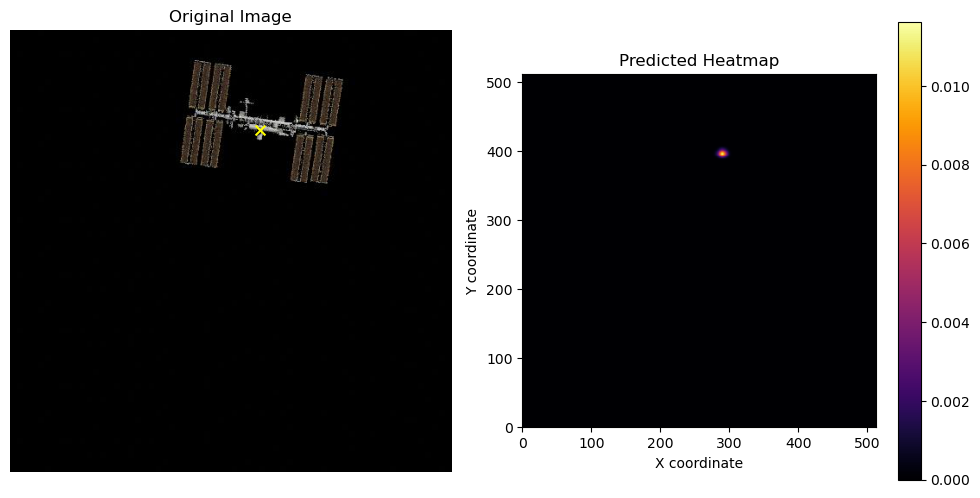

Predicted Keypoint: (289.46, 115.77) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/8968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


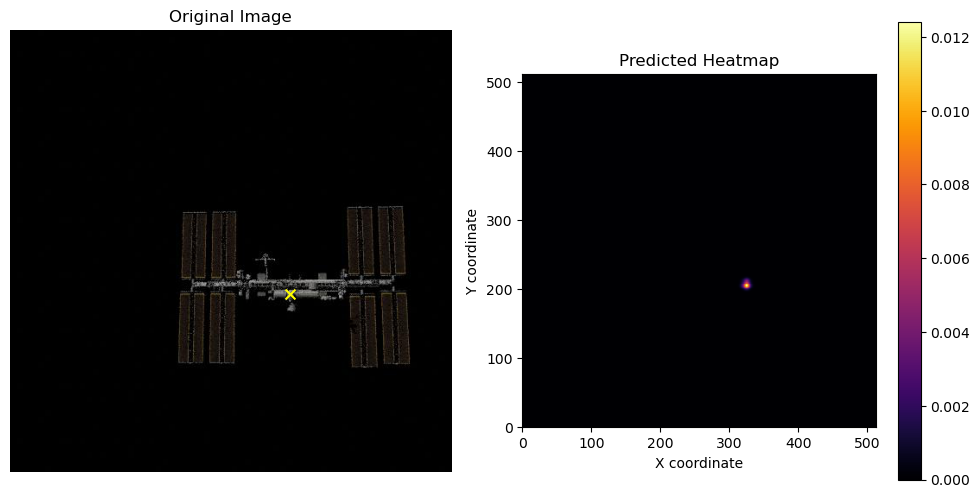

Predicted Keypoint: (324.47, 305.99) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/9559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


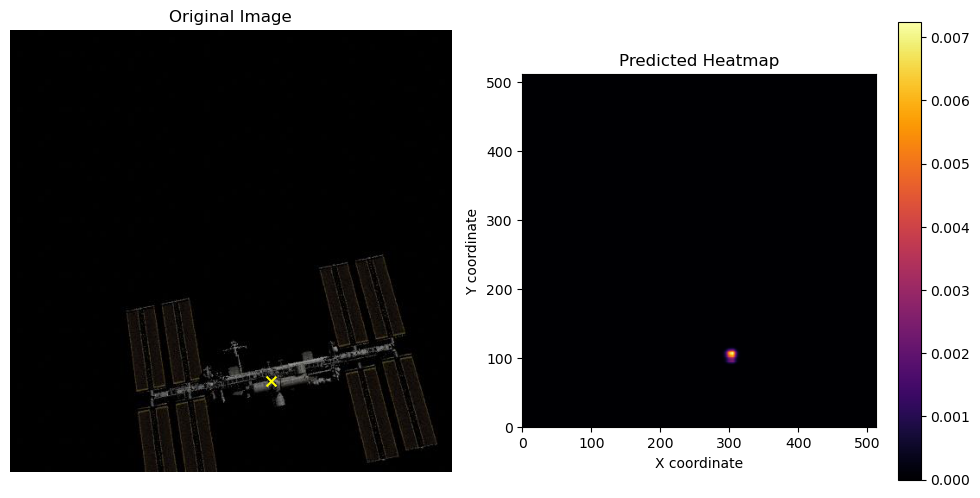

Predicted Keypoint: (302.54, 406.26) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/6890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


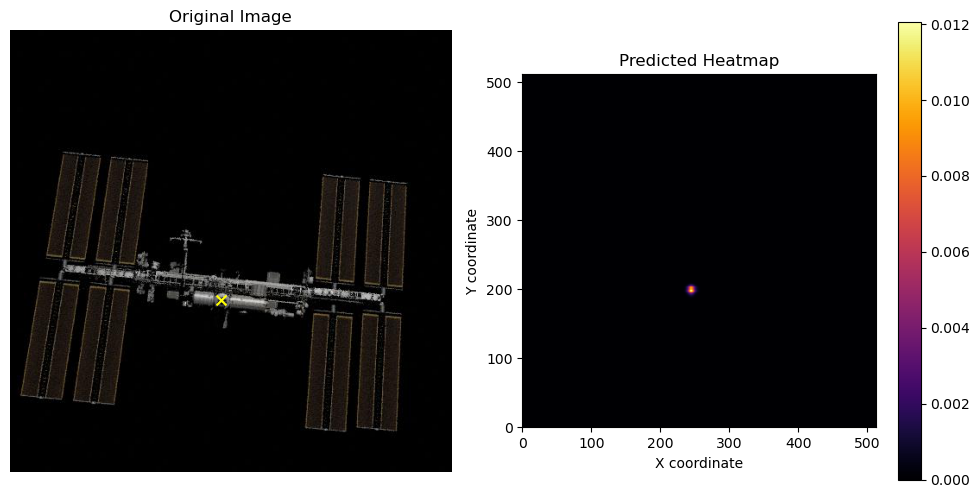

Predicted Keypoint: (244.41, 312.61) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/6345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


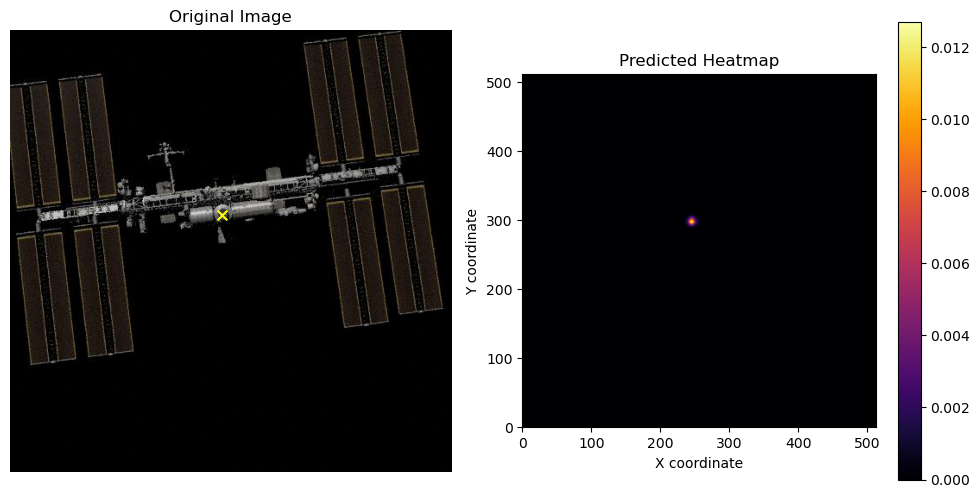

Predicted Keypoint: (245.22, 214.41) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/5076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


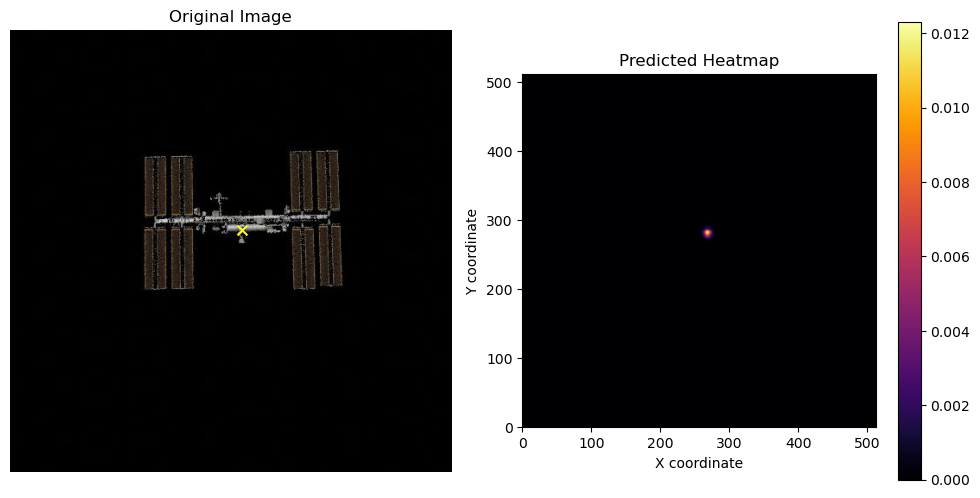

Predicted Keypoint: (268.17, 231.05) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/9538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


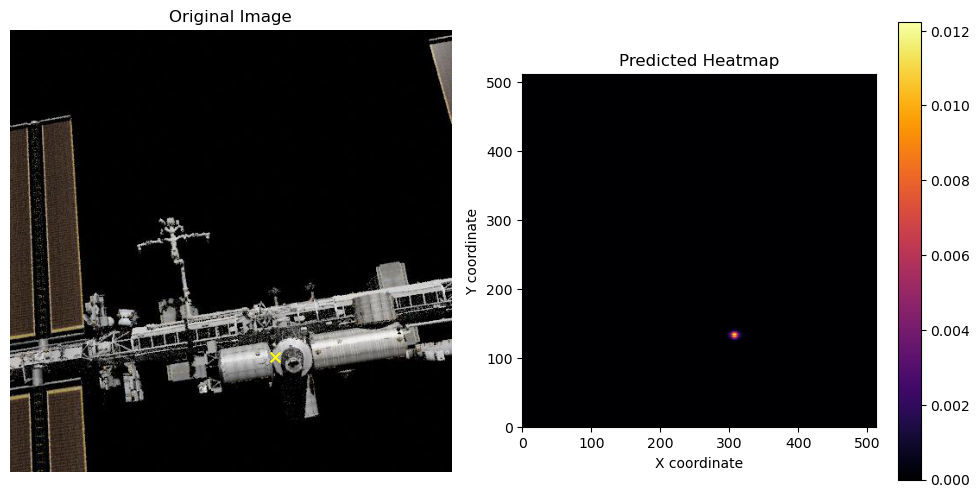

Predicted Keypoint: (306.67, 378.46) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/5152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


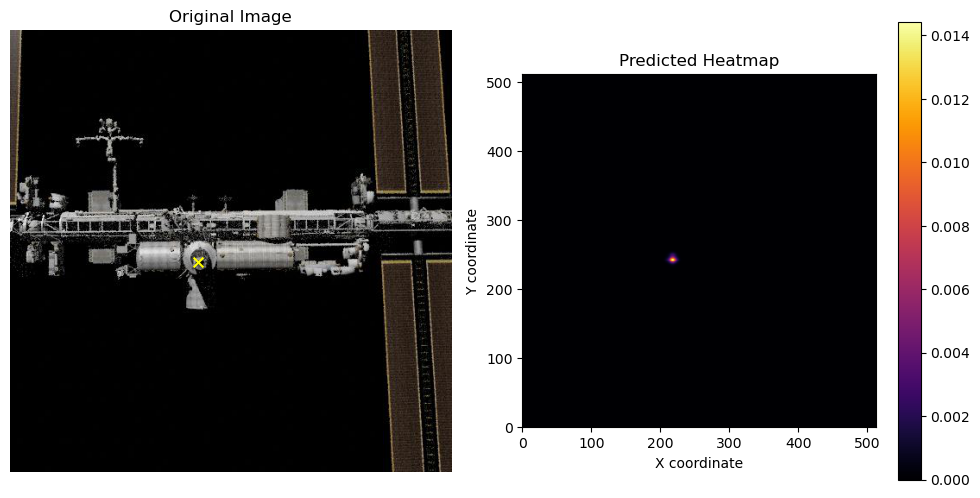

Predicted Keypoint: (217.48, 269.01) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/4294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


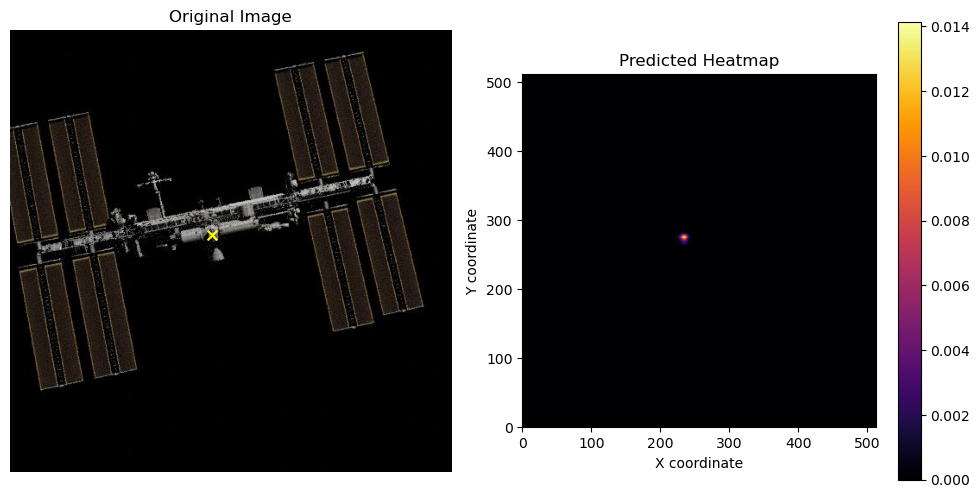

Predicted Keypoint: (233.75, 237.21) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/1396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


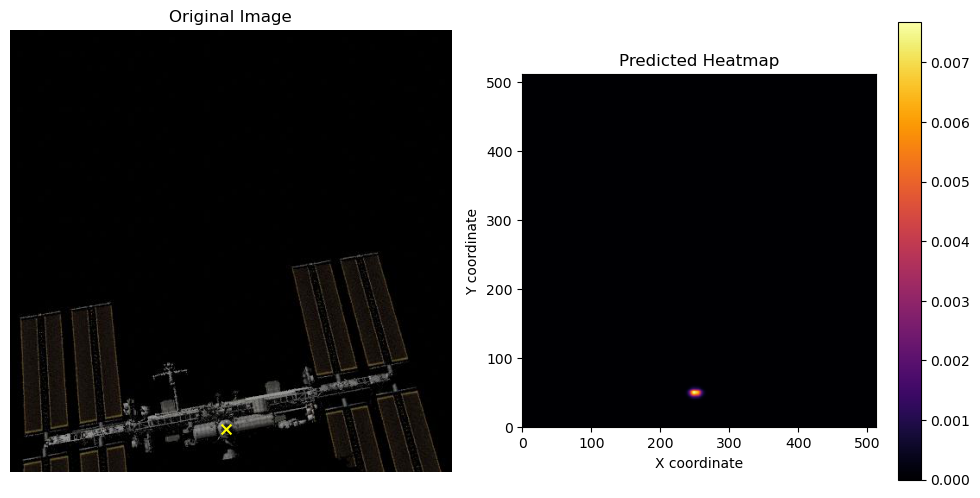

Predicted Keypoint: (250.37, 462.14) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/3935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


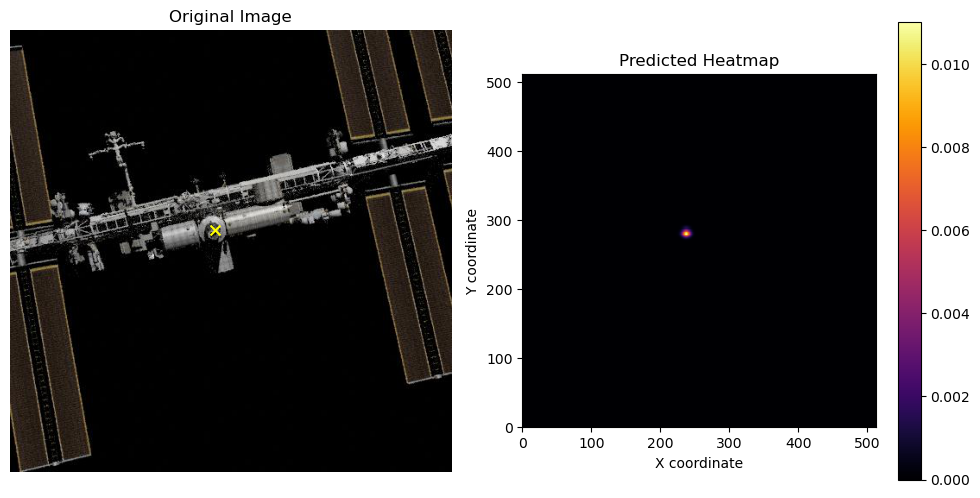

Predicted Keypoint: (237.37, 231.60) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/4780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


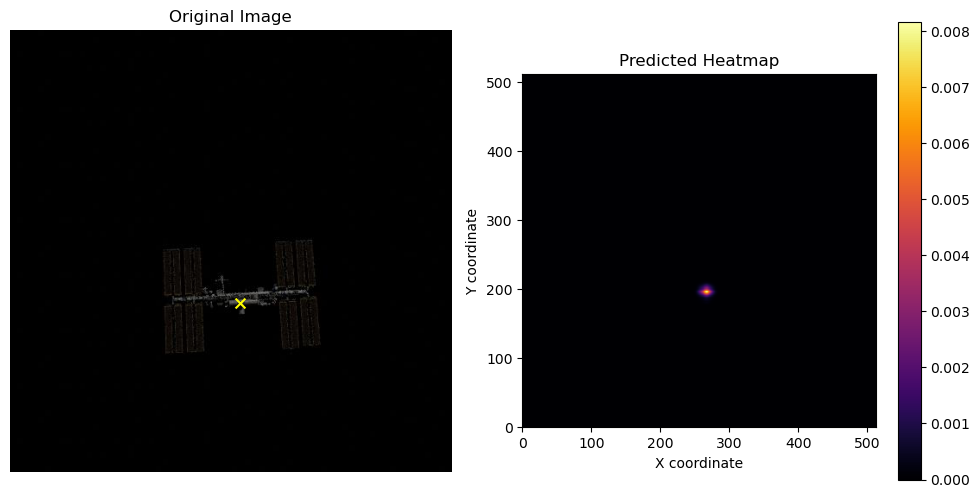

Predicted Keypoint: (266.49, 315.67) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/9359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


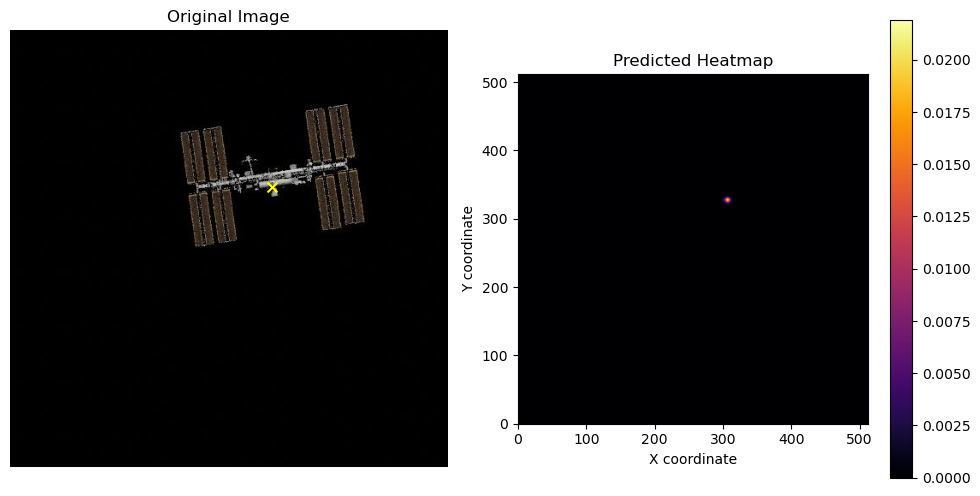

Predicted Keypoint: (305.88, 183.63) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/5909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


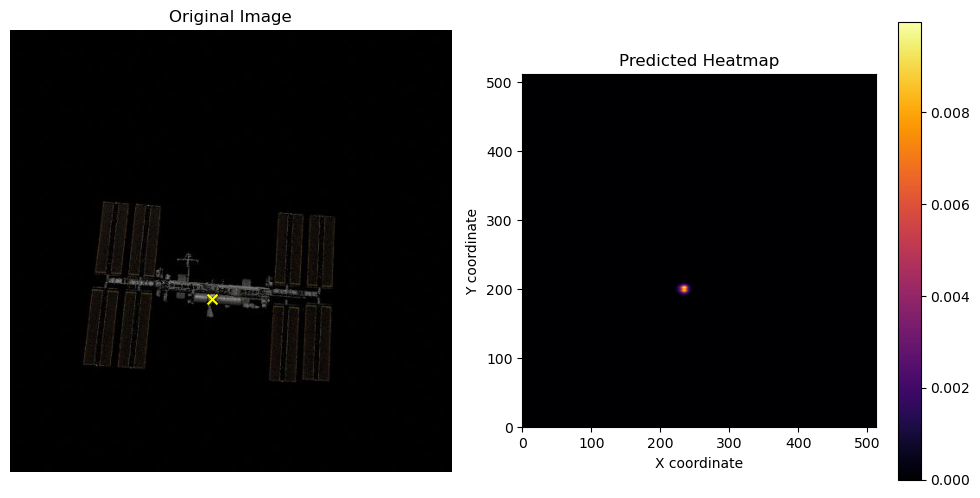

Predicted Keypoint: (233.78, 311.54) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/8687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


2025-03-03 15:03:22.513066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-03 15:03:22.613251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-03-03 15:03:22.882280: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. I

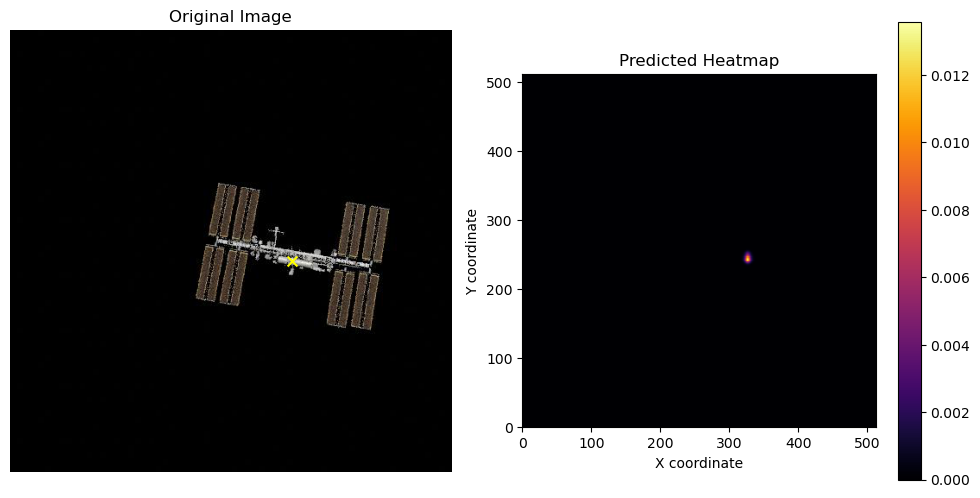

Predicted Keypoint: (326.22, 267.78) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/4731.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


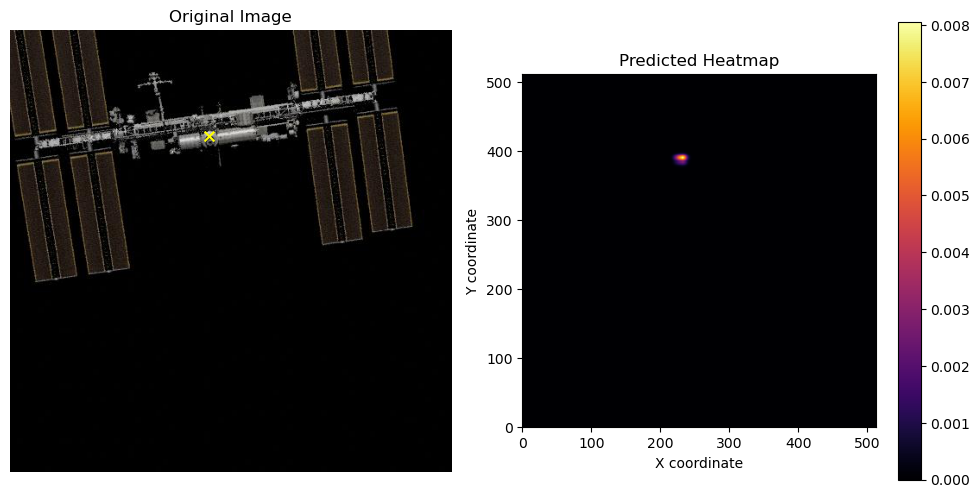

Predicted Keypoint: (230.63, 122.18) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/4738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


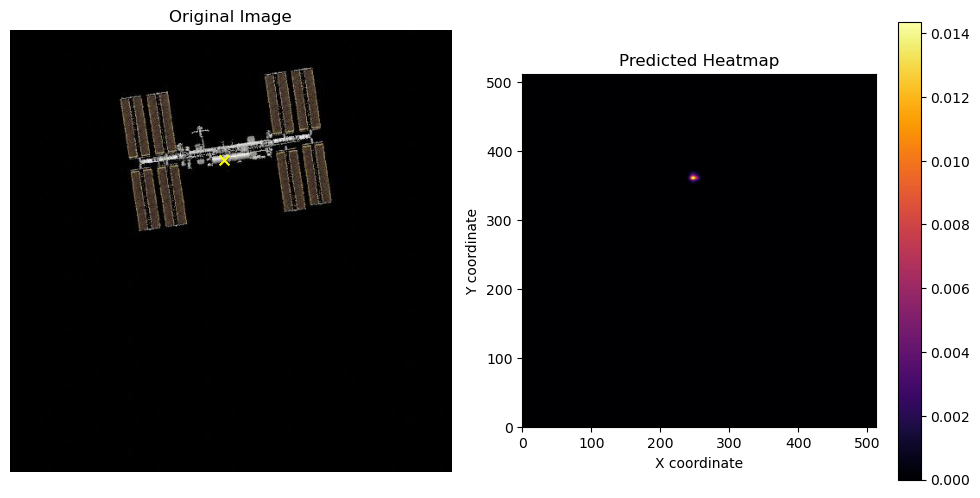

Predicted Keypoint: (247.43, 150.72) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/6358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


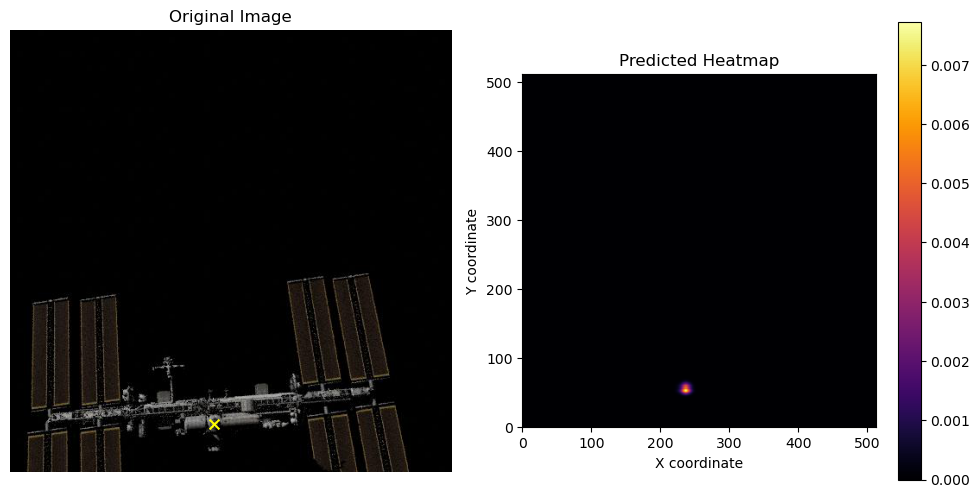

Predicted Keypoint: (236.46, 456.83) for /Users/rajkunchala/.cache/kagglehub/datasets/msafi04/iss-docking-dataset/versions/1/train/7963.jpg


In [ ]:

for image_path in test_image_paths_distances[:20]:  # Test on a few images
    image = as_image(image_path)  # Load image
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    predictions = model.predict(image)  # Get model outputs

    # Convert heatmap outputs to (x, y) coordinates
    predicted_x, predicted_y = heatmap_to_weighted_coords(predictions[1][0], predictions[2][0])

    # Reshape heatmaps to match 512x512 image size
    heatmap_x = predictions[1][0].reshape(1, 512)  # Reshape X heatmap
    heatmap_y = predictions[2][0].reshape(512, 1)  # Reshape Y heatmap

    # Create combined 2D heatmap by outer product (for visualization)
    combined_heatmap = heatmap_x * heatmap_y  # Outer product creates a 2D probability map

    # Convert TensorFlow tensor to NumPy for visualization
    image_np = image.numpy()[0]  # Remove batch dimension

    # Plot image and heatmap side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(image_np)
    axes[0].scatter(predicted_x, predicted_y, color='yellow', marker='x', s=50, label="Predicted Keypoint")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Heatmap
    im = axes[1].imshow(combined_heatmap, cmap="inferno", extent=[0, 512, 0, 512])
    axes[1].set_title("Predicted Heatmap")
    # axes[1].scatter(predicted_x, 512 - predicted_y, color='red', marker='x', s=50, label="Predicted Keypoint")
    axes[1].set_xlabel("X coordinate")
    axes[1].set_ylabel("Y coordinate")
    # axes[1].invert_yaxis()  # Flip Y-axis to match image orientation
    plt.colorbar(im, ax=axes[1])

    plt.tight_layout()
    plt.show()

    print(f"Predicted Keypoint: ({predicted_x:.2f}, {predicted_y:.2f}) for {image_path}")


In [ ]:
predictions = model.predict(test_dataset)
model.evaluate(test_dataset)

The following code snippet plots the spread in guess locations for the predictions, test set, and train set.

In [ ]:
locations = predictions[1:3]
x, y = np.array(locations[0]).flatten(), np.array(locations[1]).flatten()
print(np.array(x).shape)
print(np.array(y).shape)
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

print(train_locations[:5])

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

Now we perform the same analysis on the *best* model.

In [ ]:
best_model = tf.keras.models.load_model('best_heatmap_model.keras')
predictions = best_model.predict(test_dataset)

### Best Model Loss Table

| Dataset | Total Loss | Distance Loss | X Loss | Y Loss |
|---------|------------|--------------|--------|--------|
| Train   | ------     | ---------    | ------ | ------ |
| Test    | 0.0461     | 0.0246       | 0.0062 | 0.0153 |

In [ ]:
locations = predictions[1:3]
x, y = np.array(locations[0]).flatten(), np.array(locations[1]).flatten()
print(np.array(x).shape)
print(np.array(y).shape)
plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

print(train_locations[:5])

locations = np.array(test_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

locations = np.array(train_locations)
x, y = locations[:,0], locations[:, 1]

print(len(x))

plt.hist2d(x,y, bins=[np.arange(0, 1,12/512),np.arange(0, 1,12/512)])
plt.colorbar()
plt.show()

In [ ]:
best_model.evaluate(test_dataset)